# Blastocyst Proportions Analysis — Runnable Notebook

**Nota:** il notebook non salva immagini (solo file di testo/risultati) — `SAVE_OUTPUTS = True` nella cella di configurazione.

---
### Cosa contiene
- Setup e import
- Caricamento e validazione dati
- Elaborazione a livello paziente
- Scatter plot (proporzione blastocisti vs età)
- Boxplot per gruppi di età
- Distribuzione età
- Plot interattivo Plotly (mostrato inline)
- Analisi statistica (GLM Binomiale) e salvataggio dei risultati
- Salvataggio metadata


In [18]:

# Setup imports e configurazione
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import sys
from pathlib import Path
import logging
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from datetime import datetime

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Opzioni di comportamento: impostare SAVE_OUTPUTS=True per salvare file di output (statistiche, metadata)
SAVE_OUTPUTS = False

# Trova la root 'cellPIV' come nello script originale (con fallback)
cwd = Path().resolve()
root = cwd
for _ in range(10):
    if root.name == 'cellPIV':
        break
    if root.parent == root:
        break
    root = root.parent

fallback_root = Path('/home/phd2/Scrivania/CorsoRepo/cellPIV')
if root.name != 'cellPIV':
    root = fallback_root

if str(root) not in sys.path:
    sys.path.append(str(root))

print('Using root:', root)

# Prova a importare la config (se presente)
try:
    from config import Config_00_preprocessing as conf
    print('Imported conf from config.Config_00_preprocessing')
except Exception as e:
    conf = None
    print('Could not import conf (ok). Please set paths manually if needed.')

# Imposta percorsi fallback coerenti con lo script originale
base_dir = Path(conf.path_original_excel).parent if conf and hasattr(conf, 'path_original_excel') else Path('/home/phd2/Scrivania/CorsoRepo/cellPIV/_00b_preprocessing_excels')
path_input_excel = Path(getattr(conf, 'path_original_excel', base_dir / 'original.xlsx'))
path_double_dish = Path(getattr(conf, 'path_double_dish_excel', base_dir / 'double_dish.xlsx'))
path_added_id = Path(getattr(conf, 'path_addedID_csv', base_dir / 'added_id.csv'))
path_valid_wells = Path(getattr(conf, 'valid_wells_file', base_dir / 'datasets/valid_wells_acquisition_times.csv'))
path_filtered = Path(getattr(conf, 'filtered_blasto_dataset', base_dir / 'filtered_table.csv'))

print('Paths:')
print(' input_excel ->', path_input_excel)
print(' double_dish ->', path_double_dish)
print(' added_id CSV ->', path_added_id)
print(' valid_wells CSV ->', path_valid_wells)
print(' filtered output ->', path_filtered)

# Directory di output (modificabile)
CURRENT_DIR = Path('.').resolve()
DEFAULT_OUTPUT_DIR = CURRENT_DIR / "blast_proportions_analysis"


Using root: /home/phd2/Scrivania/CorsoRepo/cellPIV
Imported conf from config.Config_00_preprocessing
Paths:
 input_excel -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/DB morpheus UniPV.xlsx
 double_dish -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/pz con doppia dish.xlsx
 added_id CSV -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/DB_Morpheus_withID.csv
 valid_wells CSV -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/valid_wells_acquisition_times.csv
 filtered output -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/filtered_blasto_dataset.csv


In [19]:
# Definizione delle funzioni
def load_and_validate_data(file_path):
    logging.info("Loading and validating data")
    file_path = Path(file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"Input file not found: {file_path}")
    df = pd.read_csv(file_path)
    required_columns = ['patient_id', 'maternal age', 'BLASTO NY']
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    df['maternal age'] = pd.to_numeric(df['maternal age'], errors='coerce')
    df = df.dropna(subset=['maternal age', 'BLASTO NY'])
    return df

def process_patient_data(df):
    logging.info("Processing patient data")
    patient_data = df.groupby('patient_id').agg(
        age=('maternal age', 'first'),
        blast_count=('BLASTO NY', 'sum'),
        total_embryos=('BLASTO NY', 'count')
    ).reset_index()
    patient_data['proportion_blast'] = patient_data['blast_count'] / patient_data['total_embryos']
    if (patient_data['total_embryos'] == 0).any():
        raise ValueError("Found patients with 0 embryos - check data quality")
    if (patient_data['age'] < 18).any() or (patient_data['age'] > 50).any():
        logging.warning("Unusual age values detected (<18 or >50)")
    return patient_data

def generate_scatter_plots(data, save_dir=None, show=True):
    logging.info("Generating scatter plots")
    plt.figure(figsize=(12, 7))
    ax = sns.scatterplot(
        data=data,
        x='age',
        y='proportion_blast',
        size='total_embryos',
        sizes=(20, 200),
        alpha=0.6,
        hue='total_embryos',
        palette='viridis',
        legend='full'
    )
    sns.regplot(data=data, x='age', y='proportion_blast', scatter=False, color='red', ci=95, label='Trend (95% CI)')
    corr, pval = stats.pearsonr(data['age'], data['proportion_blast'])
    plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}\\np = {pval:.3f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    plt.title('Blastocyst Proportions by Maternal Age', fontsize=14)
    plt.xlabel('Maternal Age (years)', fontsize=12)
    plt.ylabel('Proportion of Blastocysts', fontsize=12)
    legend = plt.legend(title='Embryo Count', bbox_to_anchor=(1.15, 1), loc='upper left', frameon=False, ncol=2, markerscale=0.8)
    plt.subplots_adjust(right=0.78)
    if save_dir and SAVE_OUTPUTS:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_dir / 'blast_proportion_scatter.png', dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

def add_statistical_annotations(ax=None, data=None):
    # This function assumes a current axes for the boxplot
    if data is None:
        return
    groups = sorted(data['age_group'].unique())
    pairs = [(groups[i], groups[j]) for i in range(len(groups)) for j in range(i+1, len(groups))]
    group_data = [data[data['age_group'] == grp]['proportion_blast'] for grp in groups]
    try:
        f_val, p_val = stats.f_oneway(*group_data)
        plt.text(0.95, 0.95, f'ANOVA: F = {f_val:.2f}\\np = {p_val:.3f}', transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    except Exception as e:
        logging.warning(f"ANOVA failed: {e}")

def generate_boxplots(data, save_dir=None, show=True):
    logging.info("Generating boxplots")
    data = data.copy()
    data['age_group'] = pd.qcut(data['age'], q=4, precision=0)
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=data, x='age_group', y='proportion_blast', showmeans=True)
    sns.stripplot(data=data, x='age_group', y='proportion_blast', color='black', alpha=0.4, jitter=0.2)
    add_statistical_annotations(data=data)
    plt.title('Blastocyst Proportions by Age Group', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Proportion of Blastocysts', fontsize=12)
    plt.tight_layout()
    if save_dir and SAVE_OUTPUTS:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_dir / 'blast_proportion_boxplot.png', dpi=300)
    if show:
        plt.show()
    plt.close()

def generate_age_distribution(data, save_dir=None, show=True):
    logging.info("Generating age distribution plot")
    plt.figure(figsize=(10, 5))
    sns.histplot(data['age'], bins=20, kde=True)
    plt.title('Maternal Age Distribution', fontsize=14)
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Number of Patients', fontsize=12)
    if save_dir and SAVE_OUTPUTS:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_dir / 'age_distribution.png', dpi=300)
    if show:
        plt.show()
    plt.close()

def generate_interactive_plot(data, save_dir=None, show=True):
    logging.info("Generating interactive plot")
    fig = px.scatter(
        data,
        x='age',
        y='proportion_blast',
        size='total_embryos',
        color='total_embryos',
        hover_data=['patient_id', 'age', 'proportion_blast'],
        trendline="lowess",
        title="Blastocyst Proportion Analysis",
        labels={'age': 'Maternal Age', 'proportion_blast': 'Blastocyst Proportion'}
    )
    fig.update_layout(
        width=1200,
        height=600
    )

    if save_dir and SAVE_OUTPUTS:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        html_path = save_dir / "interactive_plot.html"
        fig.write_html(str(html_path))
        logging.info(f"Interactive plot saved to {html_path}")
    if show:
        fig.show()
    return fig

def perform_statistical_analysis(data, save_dir=None):
    logging.info("Performing statistical analysis")
    X = sm.add_constant(data['age'])
    # For binomial, we put successes and trials as a 2-column array
    y = data[['blast_count', 'total_embryos']]
    model = sm.GLM(y, X, family=sm.families.Binomial())
    results = model.fit()
    summary_text = results.summary().as_text()
    key_stats = {
        'pearson': stats.pearsonr(data['age'], data['proportion_blast']),
        'average_proportion': data['proportion_blast'].mean(),
        'median_age': data['age'].median()
    }
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        with open(save_dir / 'statistical_analysis.txt', 'w') as f:
            f.write("Logistic Regression Results:\n")
            f.write(summary_text)
            f.write("\n\nKey Statistics:\n")
            f.write(f"- Pearson correlation: {key_stats['pearson']}\n")
            f.write(f"- Average proportion: {key_stats['average_proportion']:.2f}\n")
            f.write(f"- Median age: {key_stats['median_age']} years\n")
    return results, key_stats



In [20]:
# === Load raw CSV ===
# Se conf è disponibile, usa path_added_id, altrimenti modifica qui sotto.
input_csv = path_added_id if 'path_added_id' in globals() else Path('added_id.csv')
print("Using input CSV:", input_csv)
raw_df = load_and_validate_data(input_csv)
print("Raw data preview:")
display(raw_df.head())
print(f"Rows: {len(raw_df)}, Columns: {len(raw_df.columns)}")


2025-09-01 17:02:30,599 - INFO - Loading and validating data


Using input CSV: /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/DB_Morpheus_withID.csv
Raw data preview:


,patient_id,dish,well,dish_well,maternal age,sperm quality,mezzo di coltura,PN,BLASTO NY,eup_aneup,...,t-biopsy,PN1a,PN2a,PN3a,altri Pna,PN1f,PN2f,PN3f,altri PNf,CP
0,54,D2013.02.19_S0675_I141,1,D2013.02.19_S0675_I141_1,37,OAT,quinns,2PN,1,euploide,...,138.374,12.1802797222222,12.1802797222222,-,-,22.6847,22.6847,-,-,2
1,54,D2013.02.19_S0675_I141,2,D2013.02.19_S0675_I141_2,37,OAT,quinns,2PN,1,euploide,...,138.376,7.68124611111111,8.681685,-,-,24.1874161111111,23.9373102775,-,-,2
2,54,D2013.02.19_S0675_I141,3,D2013.02.19_S0675_I141_3,37,OAT,quinns,2PN,0,NaN,...,-,12.1851488888888,12.6853425,-,-,53.3,53.3,-,-,2
3,54,D2013.02.19_S0675_I141,4,D2013.02.19_S0675_I141_4,37,OAT,quinns,2PN,0,NaN,...,-,10.9372783333333,11.6874552777777,-,-,29.1958563888888,29.1958563888888,-,-,2
4,54,D2013.02.19_S0675_I141,5,D2013.02.19_S0675_I141_5,37,OAT,quinns,2PN,1,Aneuploide,...,138.384,9.43941388888888,9.93965416666666,-,-,25.1951988888888,25.1951988888888,-,-,2


Rows: 6052, Columns: 36


In [21]:
# === Process patient-level data ===
patient_data = process_patient_data(raw_df)
print("Patient-level data preview:")
display(patient_data.head())
print(patient_data.describe(include='all'))

2025-09-01 17:02:30,636 - INFO - Processing patient data


Patient-level data preview:


,patient_id,age,blast_count,total_embryos,proportion_blast
0,1,38,7,12,0.583333
1,5,37,9,17,0.529412
2,7,34,2,8,0.250000
3,8,37,4,11,0.363636
4,9,40,3,8,0.375000


       patient_id         age  blast_count  total_embryos  proportion_blast
count  836.000000  836.000000   836.000000     836.000000        836.000000
mean   437.162679   38.855263     3.057416       7.239234          0.445662
std    242.054351    3.256957     1.967778       3.286363          0.225456
min      1.000000   23.000000     0.000000       1.000000          0.000000
25%    228.750000   37.000000     2.000000       5.000000          0.267045
50%    437.500000   39.000000     3.000000       7.000000          0.416667
75%    646.250000   41.000000     4.000000      10.000000          0.583333
max    855.000000   46.000000    11.000000      17.000000          1.000000


2025-09-01 17:02:30,649 - INFO - Generating scatter plots


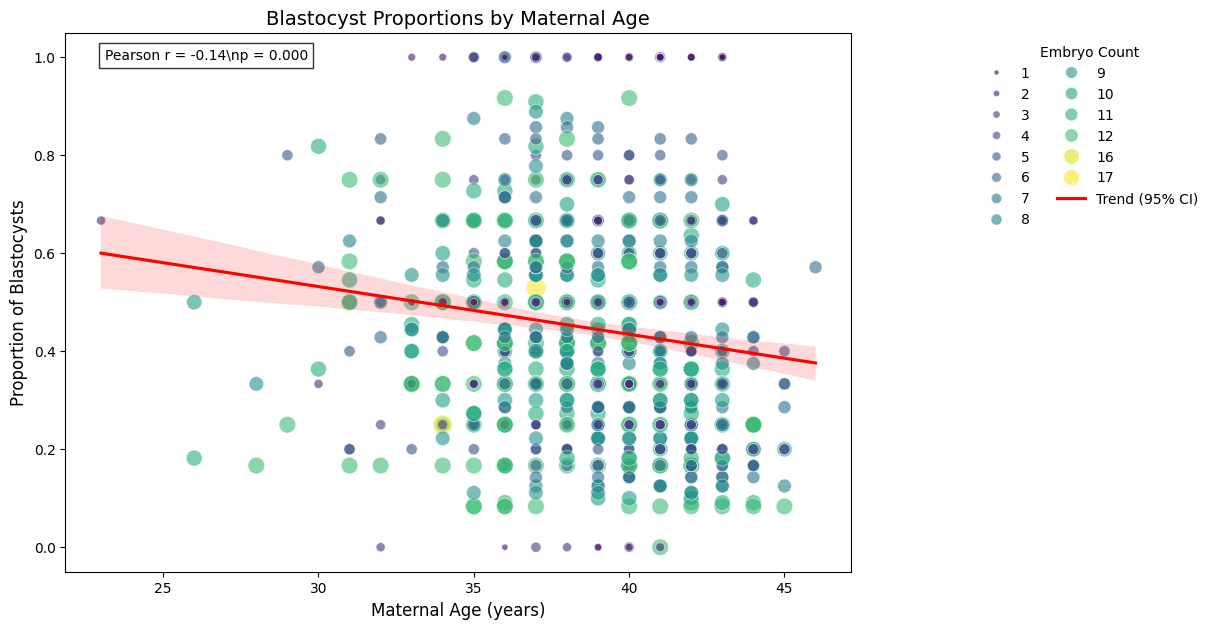

In [22]:
# === Scatter plot: Proportion vs Age ===
OUTPUT_DIR = DEFAULT_OUTPUT_DIR
generate_scatter_plots(patient_data, save_dir=OUTPUT_DIR, show=True)


2025-09-01 17:03:01,494 - INFO - Generating boxplots


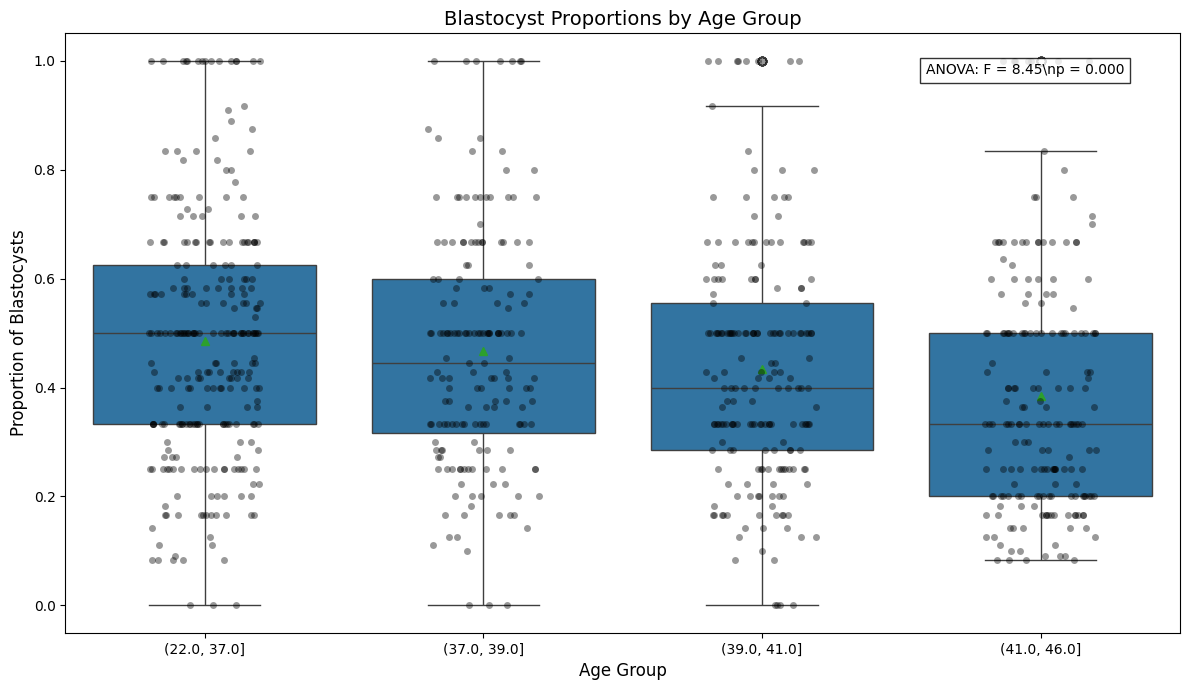

In [30]:
# === Boxplot per gruppi di età ===
generate_boxplots(patient_data, save_dir=OUTPUT_DIR, show=True)

2025-09-01 17:02:30,854 - INFO - Generating age distribution plot


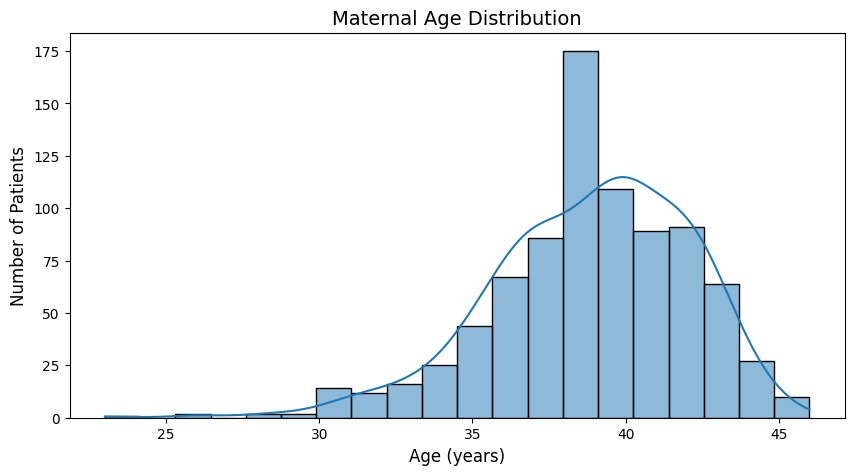

In [24]:
# === Distribuzione età ===
generate_age_distribution(patient_data, save_dir=OUTPUT_DIR, show=True)


In [25]:
# === Plot interattivo (Plotly) ===
fig = generate_interactive_plot(patient_data, save_dir=OUTPUT_DIR, show=True)

2025-09-01 17:02:30,930 - INFO - Generating interactive plot


In [28]:
# === Analisi statistica ===
results, key_stats = perform_statistical_analysis(patient_data, save_dir=OUTPUT_DIR if SAVE_OUTPUTS else None)
print("Model summary (short):")
print(results.summary().tables[0])
print("\nKey statistics:")
print(key_stats)


2025-09-01 17:02:41,251 - INFO - Performing statistical analysis


Model summary (short):
                        Generalized Linear Model Regression Results                         
Dep. Variable:     ['blast_count', 'total_embryos']   No. Observations:                  836
Model:                                          GLM   Df Residuals:                      834
Model Family:                              Binomial   Df Model:                            1
Link Function:                                Logit   Scale:                          1.0000
Method:                                        IRLS   Log-Likelihood:                -1253.9
Date:                              Mon, 01 Sep 2025   Deviance:                       446.29
Time:                                      17:02:41   Pearson chi2:                     416.
No. Iterations:                                   4   Pseudo R-squ. (CS):            0.01786
Covariance Type:                          nonrobust                                         

Key statistics:
{'pearson': PearsonRResult(sta

In [29]:
# === Salvataggio metadata ===
from datetime import datetime
import pandas as pd # Assumiamo che 'data' sia un DataFrame pandas

def create_analysis_metadata(data):
    """Calcola e restituisce un dizionario con i metadati dell'analisi."""
    metadata = {
        'analysis_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'total_patients': len(data),
        'age_range': f"{data['age'].min()} - {data['age'].max()}",
        'total_embryos': int(data['total_embryos'].sum()),
        'mean_proportion': float(round(data['proportion_blast'].mean(), 4)) # Aggiunto arrotondamento per pulizia
    }
    return metadata

# 1. Crea i metadati
analysis_metadata = create_analysis_metadata(patient_data)

# 2. Stampa i metadati a schermo (il tuo obiettivo)
print("--- Analysis Metadata ---")
for key, value in analysis_metadata.items():
    print(f"{key}: {value}")

--- Analysis Metadata ---
analysis_date: 2025-09-01 17:02:45
total_patients: 836
age_range: 23 - 46
total_embryos: 6052
mean_proportion: 0.4457
